# **Bikes Prices Regression**

Armando Acampora 5311673

https://www.kaggle.com/datasets/tysonpo/bike-ads-images-prices-specifications

In [1]:
!pip install d2l

In [2]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import scipy.stats as stats

#1. Loading Data




In [3]:
from google.colab import drive
drive.mount('/content/drive')
resources = "drive/MyDrive/Colab Notebooks/PROGETTODEEP"

Mounted at /content/drive


In [4]:
path = kagglehub.dataset_download("tysonpo/bike-ads-images-prices-specifications")
print("Path to dataset files:", path)

100%|██████████| 196M/196M [00:01<00:00, 169MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4


#2. Data Exploration

In [5]:
main = print(os.listdir(path))

['data_bike_exchange.json', 'data_ebay.json', 'images', 'combined_price-only.csv']


In [6]:
folder_jpg = os.path.join(path, 'images')
absolute_path = os.path.abspath(folder_jpg)
print(f"Il percorso assoluto della cartella 'images' è: {absolute_path}")
print(os.listdir(folder_jpg))

Il percorso assoluto della cartella 'images' è: /root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4/images
['4813.jpg', '513.jpg', '275.jpg', '562.jpg', '3619.jpg', '587.jpg', '2940.jpg', '5602.jpg', '183497630.jpg', '102223377.jpg', '2137.jpg', '5058.jpg', '8805.jpg', '7333.jpg', '7526.jpg', '2079.jpg', '3552.jpg', '8253.jpg', '6708.jpg', '6327.jpg', '8424.jpg', '127133119.jpg', '61.jpg', '171561802.jpg', '4612.jpg', '8096.jpg', '102758891.jpg', '122332274.jpg', '2422.jpg', '7282.jpg', '8375.jpg', '5619.jpg', '6029.jpg', '300.jpg', '4622.jpg', '6570.jpg', '5435.jpg', '1852.jpg', '102730882.jpg', '7762.jpg', '5288.jpg', '143123002.jpg', '3327.jpg', '965.jpg', '105545913.jpg', '8264.jpg', '8510.jpg', '177390828.jpg', '6528.jpg', '7021.jpg', '177325124.jpg', '1946.jpg', '7058.jpg', '3418.jpg', '8779.jpg', '4511.jpg', '240.jpg', '5821.jpg', '8551.jpg', '5430.jpg', '1287.jpg', '2824.jpg', '4636.jpg', '3647.jpg', '119.jpg', '414.jpg', '624.jpg', '3832.jp

In [7]:
print("Files in the main folder:", os.listdir(path))
for root, dirs, files in os.walk(path):
    print(f"\nFiles in '{root}': {files}")

Files in the main folder: ['data_bike_exchange.json', 'data_ebay.json', 'images', 'combined_price-only.csv']

Files in '/root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4': ['data_bike_exchange.json', 'data_ebay.json', 'combined_price-only.csv']

Files in '/root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4/images': ['4813.jpg', '513.jpg', '275.jpg', '562.jpg', '3619.jpg', '587.jpg', '2940.jpg', '5602.jpg', '183497630.jpg', '102223377.jpg', '2137.jpg', '5058.jpg', '8805.jpg', '7333.jpg', '7526.jpg', '2079.jpg', '3552.jpg', '8253.jpg', '6708.jpg', '6327.jpg', '8424.jpg', '127133119.jpg', '61.jpg', '171561802.jpg', '4612.jpg', '8096.jpg', '102758891.jpg', '122332274.jpg', '2422.jpg', '7282.jpg', '8375.jpg', '5619.jpg', '6029.jpg', '300.jpg', '4622.jpg', '6570.jpg', '5435.jpg', '1852.jpg', '102730882.jpg', '7762.jpg', '5288.jpg', '143123002.jpg', '3327.jpg', '965.jpg', '105545913.jpg', '8264.jpg', '8510.jpg', '1773

In [8]:
csv_file_path = '/root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4/combined_price-only.csv'
df = pd.read_csv(csv_file_path)
print(df.head(20))

    ID    Price
0    0  1399.99
1    2  2995.00
2    3  1049.00
3    4   929.35
4    5   199.00
5    6  2999.99
6    7  3950.00
7    8   900.00
8    9   900.00
9   10   469.85
10  11   585.00
11  12  1099.99
12  13  1199.00
13  14   910.00
14  15  1400.00
15  16  1795.00
16  17   249.00
17  18  6250.00
18  19  1295.00
19  20  1500.00


In [9]:
print(df['Price'].describe())

count    10052.000000
mean      1921.560166
std       2042.453002
min          0.010000
25%        475.000000
50%       1125.000000
75%       2799.990000
max      15684.630000
Name: Price, dtype: float64


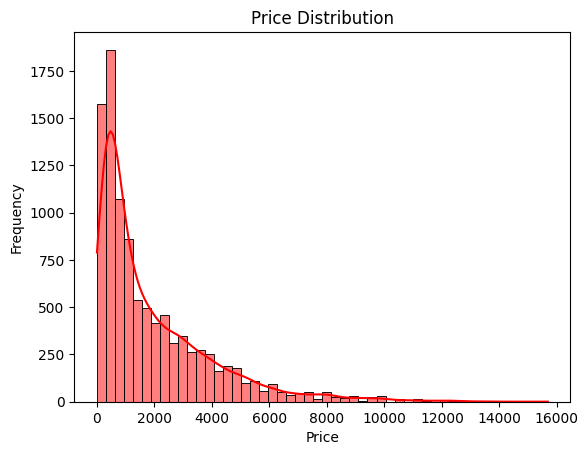

In [10]:
sns.histplot(df['Price'], bins=50, kde=True, color='red')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

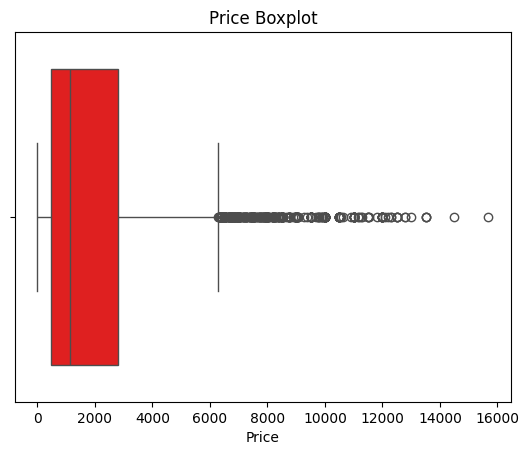

In [11]:
sns.boxplot(x=df['Price'], color='red')
plt.title("Price Boxplot")
plt.show()

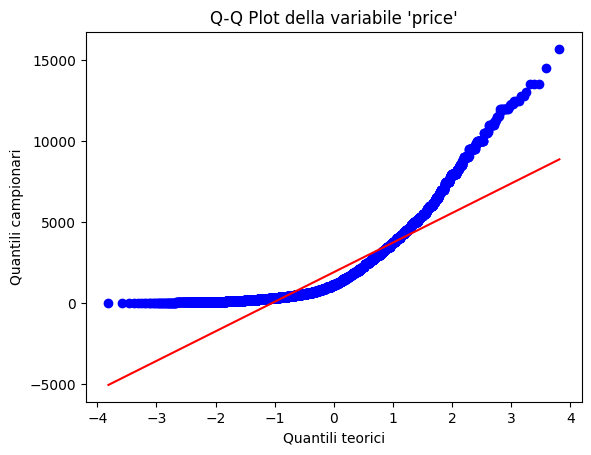

In [12]:
price = df['Price']

stats.probplot(price, dist="norm", plot=plt)
plt.title("Q-Q Plot della variabile 'price'")
plt.xlabel("Quantili teorici")
plt.ylabel("Quantili campionari")
plt.show()

#3. Data Cleaning

From the previous graphs, it's evident that the response variable (Price) has a skewed distribution. Additionally, the price range is quite large, spanning from €0.01 to €15650.

To address this, I first decided to filter out bikes priced below €50, as the minimum observed price in the dataset is €0.01, which is clearly unrealistic.

Notably, 75% of the prices fall below €2799.99, and bikes priced above €6500 are rare in the dataset. Therefore, I chose to restrict the price range to between €50 and €6500.

After applying this filter, the dataset consists of 9619 observations, down from the original 10052.

In [13]:
len_pre_filtering = df.shape[0]
df = df[(df['Price'] >= 50) & (df['Price'] <= 6500)]
len_after_filtering = df.shape[0]
f"We filtered out {len_pre_filtering - len_after_filtering} rows"

'We filtered out 433 rows'

In [14]:
len(df)

9619

#4. Data Visualization

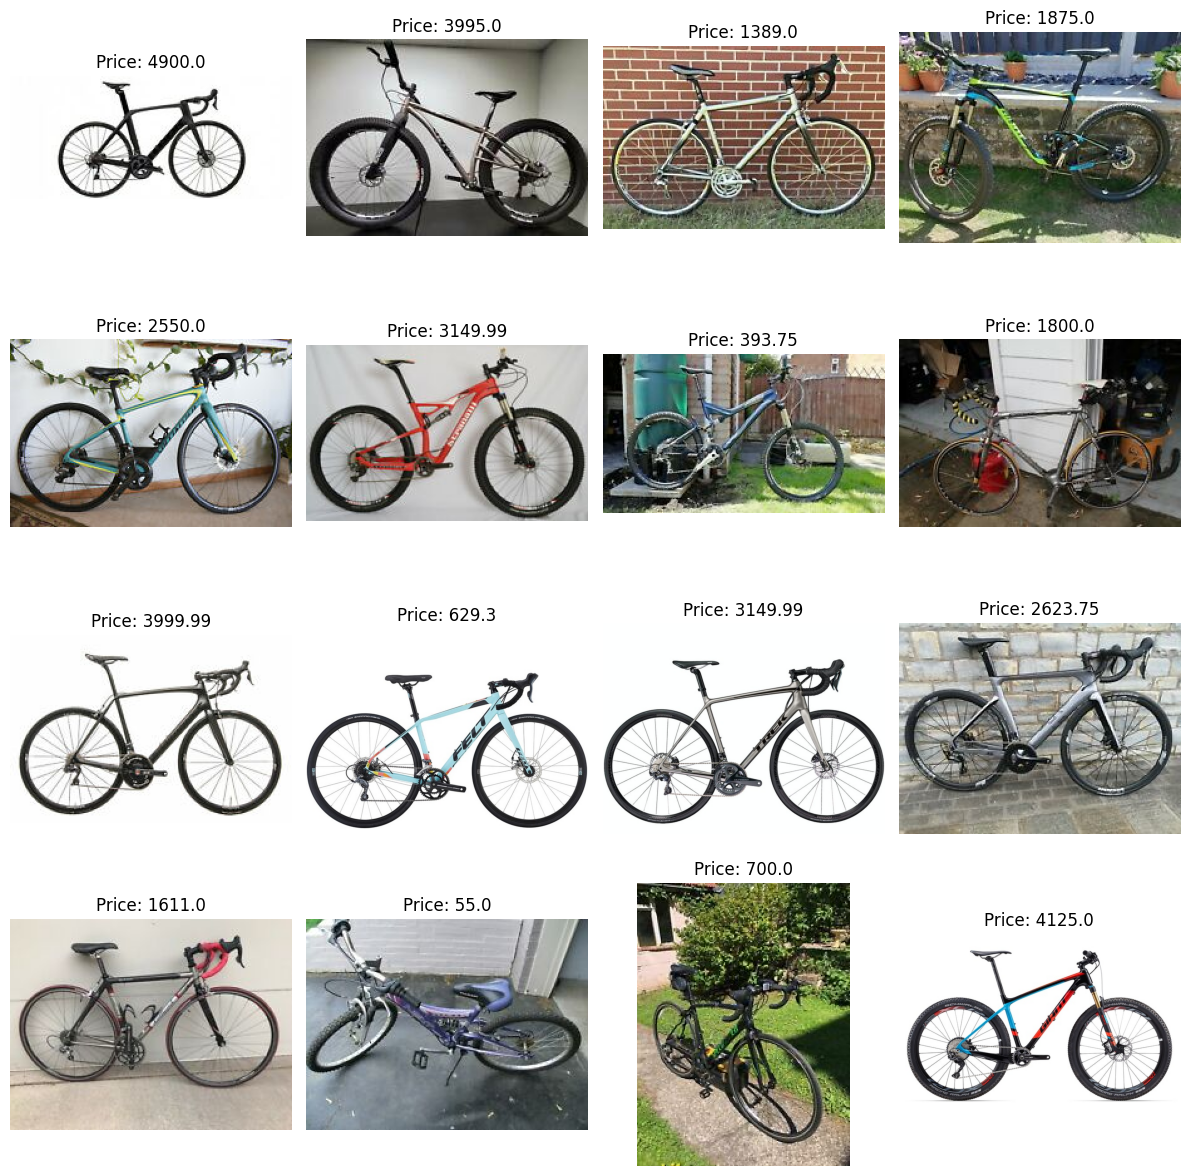

In [15]:
import random
from PIL import Image
from pathlib import Path


def display_random_bikes_in_grid(df, n=16, base_path='/root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4/images', image_extension='.jpg'):
    random_rows = df.sample(n)

    rows, cols = 4, 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    image_files = os.listdir(base_path)

    for i, (ax, (_, row)) in enumerate(zip(axes, random_rows.iterrows())):
        image_filename = str(int(row['ID'])) + '.jpg'
        path = Path(base_path) / image_filename

        if path.is_file():
            image = Image.open(path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Price: {row['Price']}")
        else:
            ax.text(0.5, 0.5, "Image not found", ha='center', va='center', fontsize=12, color='red')

    plt.tight_layout()
    plt.show()

display_random_bikes_in_grid(df, n=16, base_path='/root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4/images', image_extension='.jpg')


#5. Data Augmentation and Image Normalization

In this first block of code, I set a random seed to ensure replicability. I then resize the images to 224x224 pixels, which is a common input size required by the GoogLeNet architecture.

After this initial preprocessing, I randomly select a sample of 500 images from the dataset and compute the mean and standard deviation for each of the RGB channels.

This normalization step is crucial, as it helps to accelerate convergence and improve stability during the training process.

In [16]:
from torchvision import transforms
from pathlib import Path

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

base_path = '/root/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4/images'  # Modifica se necessario


data_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

sample_size = 500
image_tensors = []

sampled_images = random.sample(range(len(df)), min(len(df), sample_size))

for idx in sampled_images:
    row = df.iloc[idx]

    image_filename = str(int(row['ID'])) + '.jpg'

    img_path = Path(base_path) / image_filename

    if img_path.is_file():
        try:
            img = Image.open(img_path).convert("RGB")
            tensor = data_augmentation(img)
            image_tensors.append(tensor)
        except Exception as e:
            print(f"Errore con l'immagine {img_path}: {e}")
    else:
        print(f"Immagine non trovata: {img_path}")

if image_tensors:
    stacked_images = torch.stack(image_tensors)

    mean = stacked_images.mean(dim=[0, 2, 3])
    std = stacked_images.std(dim=[0, 2, 3])

    print(f"Media: {mean}")
    print(f"Deviazione standard: {std}")
else:
    print("Nessuna immagine valida trovata.")


Media: tensor([0.6015, 0.5943, 0.5577])
Deviazione standard: tensor([0.3002, 0.2982, 0.3154])


In [17]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


mean = [0.6015, 0.5943, 0.5577]
std = [0.3002, 0.2982, 0.3154]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class Bike(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_filename = str(int(row['ID'])) + '.jpg'
        img_path = Path(self.base_path) / image_filename
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(row['Price_scaled'], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label


#6. Data Splitting

I decided to split my dataset in 70% train, 15% test and 15% validation.

In [18]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(df, test_size=0.3, random_state=42)
test_dataset, val_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)

#7. Data Scaling and Model Preparation

Given the skewed distribution of the response variable, Price, I decided to apply a logarithmic transformation. In addition to this, I also applied a min-max normalization and a standardization step on the log-normalized values. The fit_transform only to the training dataset, to calculate the scaling parameters (minimum and maximum) based solely on these data, preventing information from the validation or test sets from influencing the training.  For the validation and test sets, I use transform to apply the same scaling, ensuring that all data is processed consistently.

The motivation behind applying both transformations was to reduce the wide range of the response variable. As shown below, the transformed target values now fall within the range [-2.71, 1.72]. These preprocessing steps are expected to improve the model’s performance by making the prediction of the continuous response variable more stable and optimized during training.



In [19]:
import numpy as np

class LogNormScaler:
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
        self.log_min = None
        self.log_max = None

    def fit(self, prices):
        log_prices = np.log(prices + self.epsilon)
        self.log_min = log_prices.min()
        self.log_max = log_prices.max()

    def transform(self, prices):
        log_prices = np.log(prices + self.epsilon)
        return (log_prices - self.log_min) / (self.log_max - self.log_min)

    def fit_transform(self, prices):
        self.fit(prices)
        return self.transform(prices)

    def inverse_transform(self, normalized_prices):
        if self.log_min is None or self.log_max is None:
            raise ValueError("Devi chiamare il metodo 'fit' prima di 'inverse_transform'.")
        log_prices = normalized_prices * (self.log_max - self.log_min) + self.log_min
        original_prices = np.exp(log_prices) - self.epsilon
        return original_prices


scaler = LogNormScaler(epsilon=1.0)

train_dataset['Price_scaled'] = scaler.fit_transform(train_dataset['Price'])
val_dataset['Price_scaled'] = scaler.transform(val_dataset['Price'])
test_dataset['Price_scaled'] = scaler.transform(test_dataset['Price'])

price_mean = train_dataset['Price_scaled'].mean()
price_std = train_dataset['Price_scaled'].std()

train_dataset['Price_scaled_standardized'] = (train_dataset['Price_scaled'] - price_mean) / price_std
val_dataset['Price_scaled_standardized'] = (val_dataset['Price_scaled'] - price_mean) / price_std
test_dataset['Price_scaled_standardized'] = (test_dataset['Price_scaled'] - price_mean) / price_std

pd.options.display.float_format = "{:.2f}".format

train_stats = train_dataset['Price_scaled_standardized'].describe()
val_stats = val_dataset['Price_scaled_standardized'].describe()
test_stats = test_dataset['Price_scaled_standardized'].describe()

print("Training Set:")
print(train_stats)

print("Validation Set:")
print(val_stats)

print("Test Set:")
print(test_stats)


Training Set:
count   6733.00
mean      -0.00
std        1.00
min       -2.71
25%       -0.72
50%        0.01
75%        0.85
max        1.72
Name: Price_scaled_standardized, dtype: float64
Validation Set:
count   1443.00
mean       0.07
std        1.01
min       -2.71
25%       -0.63
50%        0.14
75%        0.93
max        1.72
Name: Price_scaled_standardized, dtype: float64
Test Set:
count   1443.00
mean       0.01
std        1.00
min       -2.71
25%       -0.67
50%        0.12
75%        0.85
max        1.72
Name: Price_scaled_standardized, dtype: float64


In [20]:
import os
import pickle

resources = 'drive/MyDrive/Colab Notebooks/PROGETTODEEP'

if not os.path.exists(resources):
    os.makedirs(resources)

with open(os.path.join(resources, "lognorm.pkl"), 'wb') as f:
    pickle.dump(scaler, f)


In [21]:
import pickle

with open(resources+"/lognorm.pkl", 'wb') as f:
    pickle.dump(scaler, f)

In [22]:
train_dataset = Bike(train_dataset, base_path, transform=transform)
val_dataset = Bike(val_dataset, base_path, transform=transform)
test_dataset = Bike(test_dataset, base_path, transform=transform)

In [23]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for images, labels in train_loader:
    print(f"Batch shape: {images.size()}")
    print(f"Labels: {labels}")
    break

Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([0.7436, 0.6675, 0.6218, 0.7436, 0.5172, 0.9375, 0.5253, 0.8070, 0.5548,
        0.2613, 0.3464, 0.8893, 0.8888, 0.6335, 0.5435, 0.1866, 0.8030, 0.4496,
        0.5369, 0.8110, 0.0890, 0.6889, 0.6758, 0.8866, 0.0823, 0.7945, 0.4713,
        0.4121, 0.9255, 0.6601, 0.4764, 0.5806, 0.7569, 0.5602, 0.6976, 0.4713,
        0.0823, 0.3746, 0.5406, 0.9407, 0.8150, 0.7601, 0.6976, 0.0682, 0.4580,
        0.4114, 0.3483, 0.5435, 0.1782, 0.8405, 0.5548, 0.6976, 0.4946, 0.2239,
        0.8405, 0.5924, 0.6516, 0.6515, 0.4051, 0.2627, 0.8539, 0.7569, 0.7670,
        0.4403])


#8. Convulutional Neural Network

##GoogLeNet

GoogLeNet is a Convolutional Neural Network (CNN) introduced in 2014, based on the Inception architecture.

For my project, I implemented a custom GoogLeNet consisting of five main blocks, followed by a fully connected layer at the end.

The Adaptive Average Pooling layer reduces the spatial dimensions of the image while retaining only the most significant features.
The Flatten layer then reshapes this output into a one-dimensional feature vector, which is required as input for the fully connected layers. Together, these layers bridge the gap between the convolutional feature extractor and the regression head, enabling the model to summarize spatial features and make a single continuous prediction.

The fully connected part of the network includes a ReLU activation function, which enables the network to capture non-linear patterns. Finally, the network ends with a single output neuron, indicating that the model is designed for a regression task, like for example predicting bike prices.

In [24]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
      p1 = F.relu(self.p1_1(x))
      p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
      p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
      p4 = F.relu(self.p4_2(self.p4_1(x)))
      out = torch.cat((p1, p2, p3, p4), dim=1)
      return out

In [25]:
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten())


net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.Linear(1024, 60),
    nn.ReLU(),
    nn.Linear(60, 1))

In [26]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 60])
ReLU output shape:	 torch.Size([1, 60])
Linear output shape:	 torch.Size([1, 1])


#9. Loss Function

Given the skewed distribution of bike prices, I initially chose to use Mean Absolute Error (MAE) instead of Root Mean Squared Error (RMSE), as MAE tends to be more stable. Subsequently, I implemented a Hybrid Loss to better handle the smaller number of expensive bikes in the dataset.

To design this Hybrid Loss, I combined two components:

A Weighted MAE, which assigns more importance to expensive bikes.
A Standard MAE, which ensures stable learning and better handles the more numerous cheaper bikes.
The loss function is controlled by two parameters: alpha and lambda.

Alpha: This parameter adjusts the emphasis placed on expensive or cheaper bikes.
An alpha < 1 emphasizes cheaper bikes.
An alpha > 1 gives more weight to expensive bikes.
When alpha = 0, the weighted MAE becomes equivalent to a standard MAE.
When alpha = 1, the weighting depends solely on the ratio between the bike's true price and the mean price of all bikes.
Lambda: This parameter balances the contribution of the standard MAE and the weighted MAE within the hybrid loss.
If lambda = 0, the hybrid loss is equivalent to a standard MAE.
If lambda = 1, it becomes a fully weighted MAE.
For 0 < lambda < 1, the loss is a blend of both.
A lambda < 0.5 gives more emphasis to expensive bikes.
A lambda > 0.5 puts more focus on cheaper bikes.


In [27]:
class WeightedMAELoss(nn.Module):
    def __init__(self, alpha=1.5):
        super().__init__()
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        weights = (y_true ** self.alpha) / (y_true.mean() ** self.alpha)
        loss = weights * torch.abs(y_pred - y_true)
        return torch.mean(loss)

class HybridLoss(nn.Module):
    def __init__(self, alpha=1.5, lambda_=0.5):

        super(HybridLoss, self).__init__()
        self.weighted_mae = WeightedMAELoss(alpha)
        self.lambda_ = lambda_
        self.mae = nn.L1Loss()

    def forward(self, y_pred, y_true):
        loss_weighted = self.weighted_mae(y_pred, y_true)
        loss_mae = self.mae(y_pred, y_true)
        return self.lambda_ * loss_weighted + (1 - self.lambda_) * loss_mae


#10. Training Function and Compute MAE Function

In this block of codes I implemented two function. The first one calculate the MAE standard.

The second one it's the Training Function. This function trains a regression model using a custom HybridLoss. The training uses the Adam optimizer and Xavier initialization for stable learning.

The model is evaluated using the standard MAE to ensure interpretability. The function also tracks performance over epochs and saves the model whenever it achieves a new lowest test MAE.  

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from d2l import torch as d2l
from tqdm import tqdm

# Function to compute MAE for any dataset
def compute_mae(net, data_iter, loss_fn, device):
    """Compute the MAE for a model on a dataset."""
    net.eval()
    metric = [0.0, 0]
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X).view(-1)
            metric[0] += torch.sum(torch.abs(y_hat - y)).item()
            metric[1] += y.numel()
    mae = (metric[0] / metric[1])
    return mae

# Training Fuction
def train(net, train_iter, test_iter, num_epochs, lr, save_path="best_model.pth", device=None):
    """Train a regression model with a GPU."""
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f'Training on {device}')
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_fn = HybridLoss(alpha=1.5, lambda_=0.5)

    best_mae = float('inf')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train mae', 'test mae'])
    timer = d2l.Timer()
    initial_mae = compute_mae(net, test_iter, loss_fn, device)
    animator.add(0, (0, initial_mae))

    for epoch in range(num_epochs):
        metric = [0.0, 0]
        net.train()
        train_loss = 0.0
        total_loss = 0.0
        for X, y in tqdm(train_iter, desc=f"Epoch {epoch+1}/{num_epochs}"):
            X, y = X.to(device), y.to(device).unsqueeze(1)
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total_loss += loss.item() * X.size(0)
            metric[0] += torch.sum(torch.abs(y_hat.view(-1) - y.view(-1))).item()
            metric[1] += y.numel()

        average_train_loss = total_loss / len(train_iter.dataset)

        train_mae = metric[0] / metric[1]

        test_mae = compute_mae(net, test_iter, loss_fn, device)

        if test_mae < best_mae:
            best_mae = test_mae
            torch.save(net.state_dict(), save_path)


        animator.add(epoch + 1, (train_mae, test_mae))
        print(f'Epoch {epoch+1}/{num_epochs}, Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}')


    print(f'Finished training. Best test MAE: {best_mae:.4f}. Model saved at {save_path}')

#11. Training

Epoch 20/20, Train MAE: 0.1634, Test MAE: 0.1643
Finished training. Best test MAE: 0.1612. Model saved at best_final_regression_model.pth


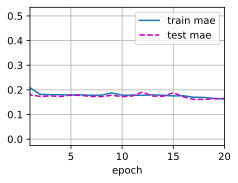

In [29]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
lr = 0.001
num_epochs = 20
train(net, train_loader, val_loader, num_epochs, lr, save_path="best_final_regression_model.pth", device=device)

#12. Model Evaluation

The first code allows to save and load the model.

The second code visualizes the model’s predictions on a batch of test images. It first performs inverse transformations to convert the predicted and true values back to the original price scale by reversing the standardization and the log-based normalization. Then, it denormalizes the test images for display. Each image is shown along with its predicted and actual price, with the title color indicating the prediction error: red if the relative error is above 15%, green otherwise. This helps evaluate the model’s performance visually and identify cases with larger prediction errors.

In [30]:
model_path = resources + "/best_final_regression_model.pth"
torch.save(net.state_dict(), model_path)
net.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

<ipython-input-31-56935ae4dd4f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(1, 1, 3).cpu()
<ipython-input-31-56935ae4dd4f>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(1, 1, 3).cpu()


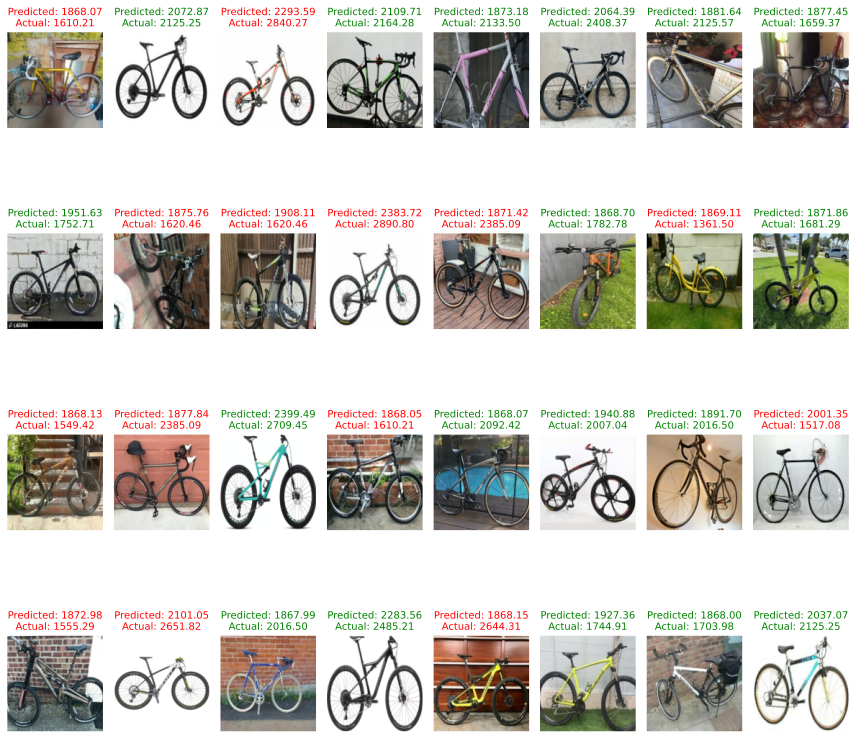

In [31]:
def inverse_standardization(data, mean, std):
    return data * std + mean


sample = next(iter(test_loader))
images, labels = sample
images = images.to(device)

net.eval()
with torch.no_grad():
    y_hat = net(images)

y_hat = y_hat.cpu().numpy()

y_hat_log_normalized = inverse_standardization(y_hat, price_mean, price_std)

y_hat_original = scaler.inverse_transform(y_hat_log_normalized)

y_true_log_normalized = inverse_standardization(labels.numpy().reshape(-1, 1), price_mean, price_std)

y_true_original = scaler.inverse_transform(y_true_log_normalized)

num_images = min(len(images), 32)
images = images[:num_images].cpu()
y_hat_original = y_hat_original[:num_images]
y_true_original = y_true_original[:num_images]

fig, axes = plt.subplots(4, 8, figsize=(12, 12))

for i, ax in enumerate(axes.flat[:num_images]):
    image = images[i].permute(1, 2, 0)
    mean = torch.tensor(mean).view(1, 1, 3).cpu()
    std = torch.tensor(std).view(1, 1, 3).cpu()
    image = image * std + mean
    error = abs(y_hat_original[i][0] - y_true_original[i][0])
    error_percentage = error / y_true_original[i][0] * 100
    color = "red" if error_percentage > 15 else "green"

    ax.imshow(image)
    ax.set_title(f"Predicted: {y_hat_original[i][0]:.2f}\nActual: {y_true_original[i][0]:.2f}",
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [32]:
import numpy as np

relative_errors = np.abs(y_true_original - y_hat_original) / y_true_original

relative_accuracy = 1 - relative_errors

mae = np.mean(np.abs((y_true_original - y_hat_original) /y_true_original))

mean_accuracy = np.mean(relative_accuracy) * 100

print(f"Mean Relative Accuracy: {mean_accuracy:.2f}%")
mean_relative_error = relative_errors.mean() * 100
print(f"Mean Relative Error: {mean_relative_error:.2f}%")
print(f"MAE: {mae}")

Mean Relative Accuracy: 85.61%
Mean Relative Error: 14.39%
MAE: 0.14387424290180206


#13. Conclusion



The goal of this project was to develop a model capable of predicting price of bikes values from images using a deep neural network.

I worked with the "bike ads images prices specifications" which contains 10052 images of bikes. To reduce the noise caused by the scarcity of data for bikes with prices greater than 6500€, I decided to focus on bikes with prices between 50€ and 6500€.

I applied several pre-processing techniques to improve the model's performance. The images were resized to 224x224 pixels and normalized using the mean and standard deviation of a sample of images. Additionally, the prices values were transformed using a logarithmic transformation, scaled using a MinMaxScaler and last but not least scaled using a standardizazion to optimize the model’s continuous prediction.

The final result, Mean Relative Accuracy reach the 85.61% on the test set, indicates a good model.